# Computational Learning: Classification, Task A

## Code setup

*This is a setup for the code execution in the user's computer, made to provide an easy execution and ensure the reproducibility of the results showcased in this work*

In [9]:
# Basic libraries that come with every Python installation
import os
import logging
import subprocess
import sys
import importlib
from typing import Union, List, Dict

These are global variables that can eb changed by the user in order to personalize the execution of the code.

In [10]:
# Folder used to download any necessary data to perform the study (datasets). You may use a relative or absolute path of your computer.
INPUT_DATA_FOLDER = "/home/mario/Uni/CompLearn/Lab2/"

# Output folder to store the results of the study
OUTPUT_FOLDER = "../"

### Error management output

Error management with a `.log` file. 

In [11]:
# Set up error logging to "errors.log"
logging.basicConfig(
    filename="errors.log",
    level=logging.ERROR,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

### Directory tree

Set up the directory folder tree

In [12]:
# Create the folder structure needed for the analysis of the results.
def create_folder_structure(input_data_folder: Union[str, os.PathLike], output_folder: Union[str, os.PathLike]) -> None:
    """
    Creates a folder structure with "data/train/metadata", "data/train/ground_truth",
    and "data/test" subfolders in the specified output directory.

    Parameters:
    output_folder (Union[str, os.PathLike]): The path to the output directory where folders will be created.

    Returns:
    None

    Raises:
    OSError: If there is an error creating directories, logs the error in "errors.log".
    """
    try:
        # Define base paths for the folder structure
        base_data_folder = os.path.join(input_data_folder, "data")
        train_metadata_folder = os.path.join(base_data_folder, "train", "metadata")
        train_ground_truth_folder = os.path.join(base_data_folder, "train", "ground_truth")
        test_folder = os.path.join(base_data_folder, "test")

        base_results_folder = os.path.join(output_folder, "results")
        # Create all necessary subfolders
        os.makedirs(train_metadata_folder, exist_ok=True)
        os.makedirs(train_ground_truth_folder, exist_ok=True)
        os.makedirs(test_folder, exist_ok=True)

        os.makedirs(base_results_folder, exist_ok=True)

    except OSError as e:
        # Log any errors that occur during directory creation
        logging.error(f"Failed to create folder structure in {output_folder}: {e}")
    

create_folder_structure(input_data_folder=INPUT_DATA_FOLDER, output_folder=OUTPUT_FOLDER)

OUTPUT_FOLDER = os.path.join(OUTPUT_FOLDER, "results")

### Install necessary libraries

The following code checks if the user alredy have the necessary libraries for execution installed. If not, it proceeds with their installation.

In [13]:
def install_libraries(libraries: List[str]) -> None:
    """
    Installs the specified libraries using pip, checking first if they are already installed.
    If running in Google Colab, it uses `!pip install` for compatibility.

    Parameters:
    libraries (List[str]): A list of library names to install.

    Returns:
    None


    Raises:
    Exception: If an error occurs during installation, logs the error in "errors.log".
    """
    # Check if running in Google Colab
    in_colab = 'google.colab' in sys.modules

    for library in libraries:
        try:
            # Check if the library is already installed by trying to import it
            importlib.import_module(library)
            print(f"Library {library} already installed.")
        
        except ImportError:
            # If the library is not installed, proceed with installation
            try:
                if in_colab:
                    # Use Google Colab's `!pip install` syntax
                    subprocess.run(f'!pip install {library}', shell=True, check=True)
                else:
                    # Standard pip install command
                    subprocess.check_call([sys.executable, "-m", "pip", "install", library])

                print(f"Installed {library} successfully.")
                
            except subprocess.CalledProcessError as e:
                # Log any errors during installation
                logging.error(f"Failed to install {library}: {e}")

In [14]:
LIBRARIES = ['requests', 'SciencePlots', 'matplotlib', 'pandas', 'numpy', "tqdm", "ipykernel"]

install_libraries(libraries=LIBRARIES)

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import scienceplots
plt.style.use(['science', 'ieee', 'std-colors'])
plt.rcParams['font.size'] = 10
plt.rcParams.update({'figure.dpi': '100'})

"""
Quitar los ejes derecho y superior de las gráficas

ax = plt.subplot(111)
(...)
ax.spines[['right', 'top']].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
"""

Library requests already installed.
Installed SciencePlots successfully.
Library matplotlib already installed.
Library pandas already installed.
Library numpy already installed.
Library tqdm already installed.
Library ipykernel already installed.


"\nQuitar los ejes derecho y superior de las gráficas\n\nax = plt.subplot(111)\n(...)\nax.spines[['right', 'top']].set_visible(False)\nax.get_xaxis().tick_bottom()\nax.get_yaxis().tick_left()\n"

## Introduction

## Systems and Methods

### Materials

Download the ISISC dataset (2019). The data may be found in this [link](https://challenge.isic-archive.com/data/#2019).

In [15]:
def download_isic_dataset(input_data_folder: Union[str, os.PathLike]) -> Dict[str, str]:
    """
    Downloads ISIC Challenge dataset files into the specified folder structure.

    Parameters:
    output_folder (Union[str, os.PathLike]): The path to the output directory where files will be saved.

    Returns:
    None

    Raises:
    Exception: If an error occurs during file download, logs the error in "errors.log".
    """
    # URLs for the ISIC Challenge dataset
    urls = {
        "train_metadata": "https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Metadata.csv",
        "train_ground_truth": "https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv",
        "test_metadata": "https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Test_Metadata.csv"
    }
    
    # File paths where each file should be saved
    paths = {
        "train_metadata": os.path.join(input_data_folder, "data", "train", "metadata", "ISIC_2019_Training_Metadata.csv"),
        "train_ground_truth": os.path.join(input_data_folder, "data", "train", "ground_truth", "ISIC_2019_Training_GroundTruth.csv"),
        "test_metadata": os.path.join(input_data_folder, "data", "test", "ISIC_2019_Test_Metadata.csv")
    }

    for key, url in tqdm(iterable=urls.items(), desc="Downloading input datasets ...", colour="green"):
        try:
            # Download file and save it to the corresponding path
            response = requests.get(url)
            response.raise_for_status()  # Raises HTTPError for bad responses (4xx, 5xx)
            
            # Write file content to the destination path
            with open(paths[key], "wb") as file:
                file.write(response.content)
            print(f"Downloaded {key} to {paths[key]}.")

        except Exception as e:
            # Log any errors during download
            logging.error(f"Failed to download {key} from {url}: {e}")

    print("Dataset ISIC successfully downloaded!")
    return paths

data_paths = download_isic_dataset(input_data_folder=INPUT_DATA_FOLDER)

Downloaded train_metadata to /home/mario/Uni/CompLearn/Lab2/data/train/metadata/ISIC_2019_Training_Metadata.csv.


Downloaded train_ground_truth to /home/mario/Uni/CompLearn/Lab2/data/train/ground_truth/ISIC_2019_Training_GroundTruth.csv.


Downloaded test_metadata to /home/mario/Uni/CompLearn/Lab2/data/test/ISIC_2019_Test_Metadata.csv.
Dataset ISIC successfully downloaded!


### Methodology

#### Exploratory Data Analysis of the Target Variable

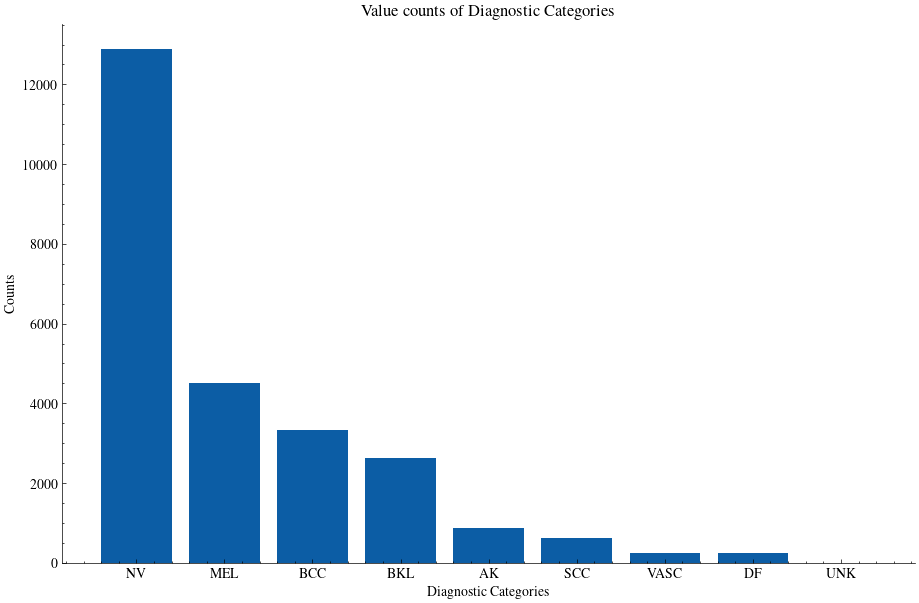

In [16]:
def get_value_counts_per_diagnostic_category(
    csv_path: str, plot: bool = True, **plot_kwargs
) -> pd.Series:
    """
    Given a ground truth CSV path, returns the counts per target class.
    Assumes a dummy encoding of the variables and that the first column is the ID of the sample.

    Parameters:
    -------------
    csv_path (str): Path to the ground truth csv
    plot (bool): Whether to plot the distribution or not
    
    Returns:
    -------------
    pd.Series: Series object with indexes as classes and values as sample counts per class
    """
    train_ground_truth = pd.read_csv(csv_path)
    counts = train_ground_truth.iloc[:, 1:].apply(lambda x: sum(x)).sort_values(ascending=False)
    
    # If plot is True, pass additional kwargs to the plotting function
    if plot:
        plot_value_counts_per_diagnostic_category(counts=counts, **plot_kwargs)

    return counts

def plot_value_counts_per_diagnostic_category(
    counts: pd.Series, save: bool = True, output: str = OUTPUT_FOLDER
) -> None:
    """
    Plots the distribution of counts per target class.

    Parameters:
    -------------
    counts (pd.Series): Series containing count values for each class
    save (bool): Whether to save the plot as a png
    output (str): Path to the output folder where the plot will be saved
    
    Returns:
    -------------
    None
    """
    plt.figure(figsize=(11,7))
    ax = plt.subplot(111)
    plt.bar(x=counts.index, height=counts.values)
    ax.spines[['right', 'top']].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    plt.title("Value counts of Diagnostic Categories")
    plt.xlabel("Diagnostic Categories")
    plt.ylabel("Counts")
    if save: 
        os.makedirs(output, exist_ok=True)
        plt.savefig(os.path.join(output, "counts_per_target_class.png"))
    plt.show()

# Call

counts = get_value_counts_per_diagnostic_category(
    csv_path=data_paths["train_ground_truth"],
    plot=True,
    save=True,
    output=OUTPUT_FOLDER
)

The **imbalance ratio (IR)** for each class is calculated by dividing the count of the largest class by the count of each other class. Specifically:

$$
\text{Imbalance Ratio for Class i} = \frac{\text{Count of Largest Class}}{\text{Count of Class i}}
$$

In the ISIC Dataset:
- The largest class is "NV" with a count of 12,875.
- For each class, we divide 12,875 by the class count to obtain the imbalance ratio.

For example:
- **MEL**: $ \text{IR} = \frac{12875}{4522} \approx 2.85 $
- **BCC**: $ \text{IR} = \frac{12875}{3323} \approx 3.87 $
- **UNK**: Since the count is 0, dividing by 0 would be undefined. We replace this with `<NA>`.

In [17]:
def calculate_class_distribution_metrics(counts: pd.Series) -> pd.DataFrame:
    """
    Calculates additional metrics to assess the class distribution in a dataset.

    Parameters:
    -------------
    counts (pd.Series): Series containing count values for each class
    
    Returns:
    -------------
    pd.DataFrame: DataFrame containing metrics like percentage distribution, 
                  imbalance ratio, mean, and variance of sample counts per category.
    """
    
    total_samples = counts.sum()
    
    # Calculate percentage distribution
    percentage_distribution = (counts / total_samples) * 100
    
    # Calculate imbalance ratio (IR) with respect to the largest class
    max_count = counts.max()
    imbalance_ratio = max_count / counts.replace(0, pd.NA)  # avoid division by zero

    # Create a DataFrame to store the results
    metrics_df = pd.DataFrame({
        "Class": counts.index,
        "Counts": counts.values.astype(int),
        "Percentage": percentage_distribution.round(2).values,
        "Imbalance Ratio": imbalance_ratio.round(2).values
    })
    
    return metrics_df

# Call

metrics_df = calculate_class_distribution_metrics(counts=counts)
metrics_df
counts

NV      12875.0
MEL      4522.0
BCC      3323.0
BKL      2624.0
AK        867.0
SCC       628.0
VASC      253.0
DF        239.0
UNK         0.0
dtype: float64

#### Exploratory Data Analysis of the other Metadata Variables

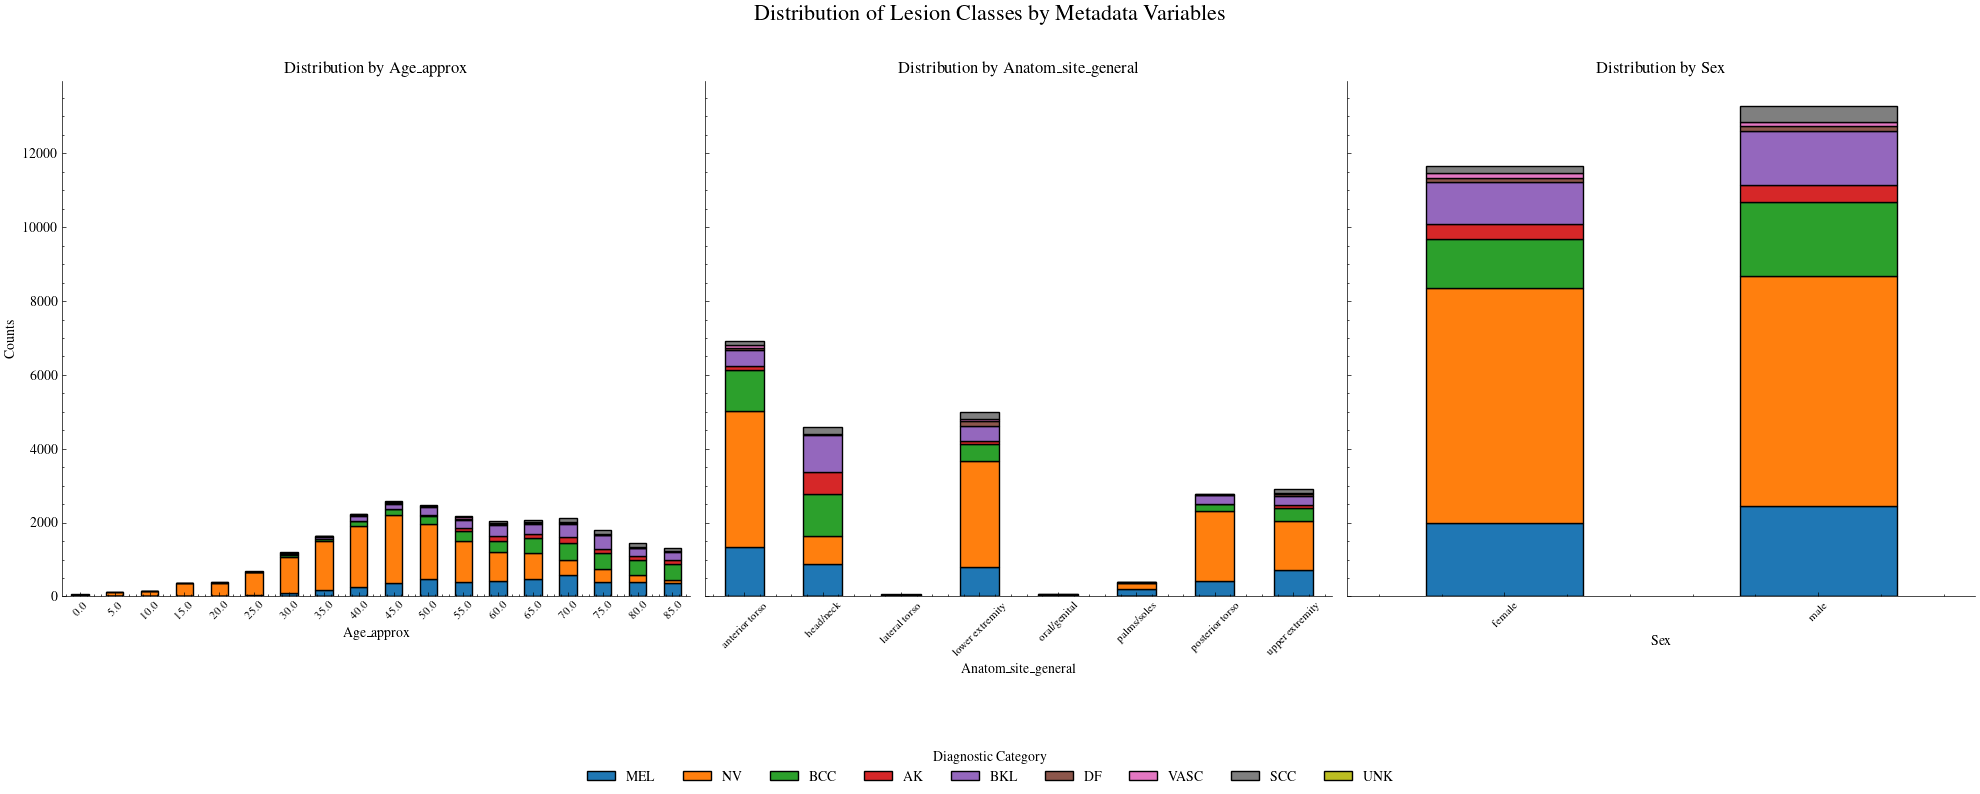

In [18]:
def plot_class_distribution_by_metadata(metadata_path: str, groundtruth_path: str, save: bool = True, output: str = "output_folder") -> None:
    """
    Generates stacked bar plots for each metadata variable (age_approx, anatom_site_general, sex),
    with bars colored according to the distribution of lesion classes from the groundtruth.
    A unified legend for all plots is displayed at the bottom of the figure.

    Parameters:
    -------------
    metadata_path (str): Path to the metadata CSV file.
    groundtruth_path (str): Path to the ground truth CSV file.
    save (bool): Whether to save the plot as a png.
    output (str): Path to the output folder where the plot will be saved.

    Returns:
    -------------
    None
    """
    
    # Load the metadata and ground truth datasets
    metadata = pd.read_csv(metadata_path)
    groundtruth = pd.read_csv(groundtruth_path)
    
    # Merge datasets on the sample ID (assuming the ID column is the first in both files)
    data = pd.merge(metadata, groundtruth, left_on=metadata.columns[0], right_on=groundtruth.columns[0])
    
    # Define columns and labels for plotting
    variables = ["age_approx", "anatom_site_general", "sex"]
    class_labels = groundtruth.columns[1:]  # The columns from the ground truth file represent lesion classes

    # Set up the figure for multiple subplots
    fig, axes = plt.subplots(1, len(variables), figsize=(20, 7), sharey=True)
    fig.suptitle("Distribution of Lesion Classes by Metadata Variables", fontsize=16)

    # Color map for class labels
    color_map = plt.get_cmap("tab10")
    colors = color_map(range(len(class_labels)))

    # Loop through each metadata variable to create stacked bar plots
    for i, var in enumerate(variables):
        # Group by the variable and class labels to get counts
        counts = data.groupby([var])[class_labels].sum()

        # Plot stacked bar chart without individual legends
        counts.plot(kind="bar", stacked=True, ax=axes[i], color=colors, edgecolor="black", legend=False)

        # Set plot labels and titles
        axes[i].set_title(f"Distribution by {var.capitalize()}")
        axes[i].set_xlabel(var.capitalize())
        axes[i].set_ylabel("Counts" if i == 0 else "")
        axes[i].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i].spines[['right', 'top']].set_visible(False)
        axes[i].get_xaxis().tick_bottom()
        axes[i].get_yaxis().tick_left()

    # Create a unified legend at the bottom of the figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, class_labels, loc="lower center", ncol=len(class_labels), bbox_to_anchor=(0.5, -0.15), title="Diagnostic Category")

    # Adjust layout and save
    plt.tight_layout(rect=[0, 0, 1, 0.97])  
    if save:
        os.makedirs(output, exist_ok=True)
        plt.savefig(os.path.join(output, "class_distribution_by_metadata_with_unified_legend.png"), bbox_inches="tight")
    plt.show()

# Call
plot_class_distribution_by_metadata(
    metadata_path=data_paths["train_metadata"],
    groundtruth_path=data_paths["train_ground_truth"],
    output=OUTPUT_FOLDER
)

#### Metrics implementation

**Input data**

In [19]:
data = {
    "Method": ["A", "B", "C", "D", "E"],
    "TP": [100, 80, 25, 50, 0],
    "FP": [900, 125, 25, 50, 0],
    "FN": [0, 20, 75, 50, 100],
    "TN": [0, 775, 875, 850, 900]
}
results_df = pd.DataFrame(data)

**Metrics**

In [20]:
class Metrics:
    """
    A class to calculate various performance metrics for machine learning models 
    based on confusion matrix values (TP, FP, FN, TN) provided in a DataFrame.
    """
    
    def __init__(self, results_df: pd.DataFrame, method_col: str = "Method") -> None:
        """
        Initializes the Metrics class with a DataFrame of results.

        Description:
        -------------
        This constructor initializes the Metrics class with the provided DataFrame,
        ensuring that it contains valid data for computing metrics (non-negative confusion 
        matrix values and presence of the specified method column).

        Parameters:
        -------------
        results_df (pd.DataFrame): DataFrame containing TP, FP, FN, TN for each method.
        method_col (str): Column name that contains the model/method name.

        Raises:
        -------------
        ValueError: If the DataFrame contains negative values or if method_col does not exist.
        """
        if method_col not in results_df.columns:
            raise ValueError(f"The column '{method_col}' does not exist in the DataFrame.")
        
        if (results_df[['TP', 'FP', 'FN', 'TN']] < 0).any().any():
            raise ValueError("Confusion matrix values (TP, FP, FN, TN) must be non-negative.")
        
        self.results_df = results_df
        self.method_col = method_col

    def _precision(self, tp: int, fp: int) -> Union[float, str]:
        """
        Calculates Precision (PR): TP / (TP + FP)

        Description:
        -------------
        Precision, also called positive predictive value, calculates the proportion 
        of true positives among the total predicted positives.

        Parameters:
        -------------
        tp (int): True Positives
        fp (int): False Positives
        
        Returns:
        -------------
        float: Precision score, or NaN if division by zero occurs.

        References:
        -------------
        M. Powers, "Evaluation: From Precision, Recall and F-Measure to ROC, 
        Informedness, Markedness & Correlation," Journal of Machine Learning Technologies, 2011.
        """
        try:
            return tp / (tp + fp) if (tp + fp) > 0 else np.nan
        except Exception as e:
            return np.nan, f"Error in calculating precision: {e}"

    def _recall(self, tp: int, fn: int) -> Union[float, str]:
        """
        Calculates Recall (RC): TP / (TP + FN)

        Description:
        -------------
        Recall, also called sensitivity or true positive rate, calculates the proportion 
        of true positives among all actual positives.

        Parameters:
        -------------
        tp (int): True Positives
        fn (int): False Negatives
        
        Returns:
        -------------
        float: Recall score, or NaN if division by zero occurs.

        References:
        -------------
        D. Chicco and G. Jurman, "The advantages of the Matthews correlation 
        coefficient (MCC) over F1 score and accuracy in binary classification evaluation," 
        BMC Genomics, 2020.
        """
        try:
            return tp / (tp + fn) if (tp + fn) > 0 else np.nan
        except Exception as e:
            return np.nan, f"Error in calculating recall: {e}"

    def _specificity(self, tn: int, fp: int) -> Union[float, str]:
        """
        Calculates Specificity (SP): TN / (TN + FP)

        Description:
        -------------
        Specificity measures the proportion of true negatives among all actual negatives.

        Parameters:
        -------------
        tn (int): True Negatives
        fp (int): False Positives
        
        Returns:
        -------------
        float: Specificity score, or NaN if division by zero occurs.

        References:
        -------------
        E. R. Dougherty, "Validation of statistical computational models in bioinformatics," 
        Current Protocols in Bioinformatics, 2001.
        """
        try:
            return tn / (tn + fp) if (tn + fp) > 0 else np.nan
        except Exception as e:
            return np.nan, f"Error in calculating specificity: {e}"

    def _false_negative_rate(self, fn: int, tp: int) -> Union[float, str]:
        """
        Calculates False Negative Rate (FNR): FN / (TP + FN)

        Description:
        -------------
        The false negative rate is the proportion of actual positives that were incorrectly
        classified as negatives.

        Parameters:
        -------------
        fn (int): False Negatives
        tp (int): True Positives
        
        Returns:
        -------------
        float: False Negative Rate score, or NaN if division by zero occurs.
        """
        try:
            return fn / (tp + fn) if (tp + fn) > 0 else np.nan
        except Exception as e:
            return np.nan, f"Error in calculating FNR: {e}"

    def _false_positive_rate(self, fp: int, tn: int) -> Union[float, str]:
        """
        Calculates False Positive Rate (FPR): FP / (FP + TN)

        Description:
        -------------
        The false positive rate is the proportion of actual negatives that were incorrectly 
        classified as positives.

        Parameters:
        -------------
        fp (int): False Positives
        tn (int): True Negatives
        
        Returns:
        -------------
        float: False Positive Rate score, or NaN if division by zero occurs.
        """
        try:
            return fp / (fp + tn) if (fp + tn) > 0 else np.nan
        except Exception as e:
            return np.nan, f"Error in calculating FPR: {e}"

    def _accuracy(self, tp: int, tn: int, fp: int, fn: int) -> Union[float, str]:
        """
        Calculates Accuracy (ACC): (TN + TP) / (TP + FN + FP + TN)

        Description:
        -------------
        Accuracy measures the proportion of correctly classified instances (both positives and negatives)
        among all instances.

        Parameters:
        -------------
        tp (int): True Positives
        tn (int): True Negatives
        fp (int): False Positives
        fn (int): False Negatives
        
        Returns:
        -------------
        float: Accuracy score, or NaN if division by zero occurs.
        """
        try:
            return (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else np.nan
        except Exception as e:
            return np.nan, f"Error in calculating accuracy: {e}"

    def _jaccard_index(self, tp: int, fp: int, fn: int) -> Union[float, str]:
        """
        Calculates Jaccard Index (J): TP / (TP + FN + FP)

        Description:
        -------------
        The Jaccard Index, or Intersection over Union, measures the overlap between the true 
        positives and the union of predicted positives and actual positives.

        Parameters:
        -------------
        tp (int): True Positives
        fp (int): False Positives
        fn (int): False Negatives
        
        Returns:
        -------------
        float: Jaccard Index score, or NaN if division by zero occurs.
        """
        try:
            return tp / (tp + fn + fp) if (tp + fn + fp) > 0 else np.nan
        except Exception as e:
            return np.nan, f"Error in calculating Jaccard index: {e}"

    def _f_measure(self, precision: float, recall: float) -> Union[float, str]:
        """
        Calculates F-measure (Fm): (2 * PR * RC) / (PR + RC)

        Description:
        -------------
        The F-measure combines precision and recall into a single score by taking their harmonic mean,
        giving an overall measure of a model's accuracy on the positive class.

        Parameters:
        -------------
        precision (float): Precision score
        recall (float): Recall score
        
        Returns:
        -------------
        float: F-measure score, or NaN if division by zero occurs.
        """
        try:
            return (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else np.nan
        except Exception as e:
            return np.nan, f"Error in calculating F-measure: {e}"
        
    def performance_analysis(self) -> pd.DataFrame:
        """
        Calculates all metrics for each model and returns a DataFrame with results.

        Returns:
        -------------
        pd.DataFrame: DataFrame containing the method name and one column per metric.
        """
        metrics_data = {
            "Method": [],
            "Precision": [],
            "Recall": [],
            "Specificity": [],
            "FNR": [],
            "FPR": [],
            "Accuracy": [],
            "Jaccard Index": [],
            "F1": []
        }

        # Iterate over each row in the results DataFrame with a progress bar
        for _, row in tqdm(self.results_df.iterrows(), total=self.results_df.shape[0], desc="Calculating metrics"):
            tp, fp, fn, tn = row["TP"], row["FP"], row["FN"], row["TN"]
            metrics_data["Method"].append(row[self.method_col])
            
            # Calculate each metric
            precision = self._precision(tp, fp)
            recall = self._recall(tp, fn)
            specificity = self._specificity(tn, fp)
            fnr = self._false_negative_rate(fn, tp)
            fpr = self._false_positive_rate(fp, tn)
            accuracy = self._accuracy(tp, tn, fp, fn)
            jaccard_index = self._jaccard_index(tp, fp, fn)
            f_measure = self._f_measure(precision, recall)
            
            # Append calculated metrics to the data dictionary
            metrics_data["Precision"].append(precision)
            metrics_data["Recall"].append(recall)
            metrics_data["Specificity"].append(specificity)
            metrics_data["FNR"].append(fnr)
            metrics_data["FPR"].append(fpr)
            metrics_data["Accuracy"].append(accuracy)
            metrics_data["Jaccard Index"].append(jaccard_index)
            metrics_data["F1"].append(f_measure)

        # Convert the metrics data dictionary to a DataFrame
        return pd.DataFrame(metrics_data)

**Execution**

In [21]:
# Create an instance of the Metrics class
metrics = Metrics(results_df=results_df, method_col="Method")
performance = metrics.performance_analysis()
performance_per_row = performance.set_index("Method").transpose()
performance_per_row

Calculating metrics: 100%|██████████| 5/5 [00:00<00:00, 6529.12it/s]


Method,A,B,C,D,E
Precision,0.100000,0.390244,0.500000,0.500000,NaN
Recall,1.000000,0.800000,0.250000,0.500000,0.0
Specificity,0.000000,0.861111,0.972222,0.944444,1.0
FNR,0.000000,0.200000,0.750000,0.500000,1.0
FPR,1.000000,0.138889,0.027778,0.055556,0.0
Accuracy,0.100000,0.855000,0.900000,0.900000,0.9
Jaccard Index,0.100000,0.355556,0.200000,0.333333,0.0
F1,0.181818,0.524590,0.333333,0.500000,NaN


**Performance Analysis**

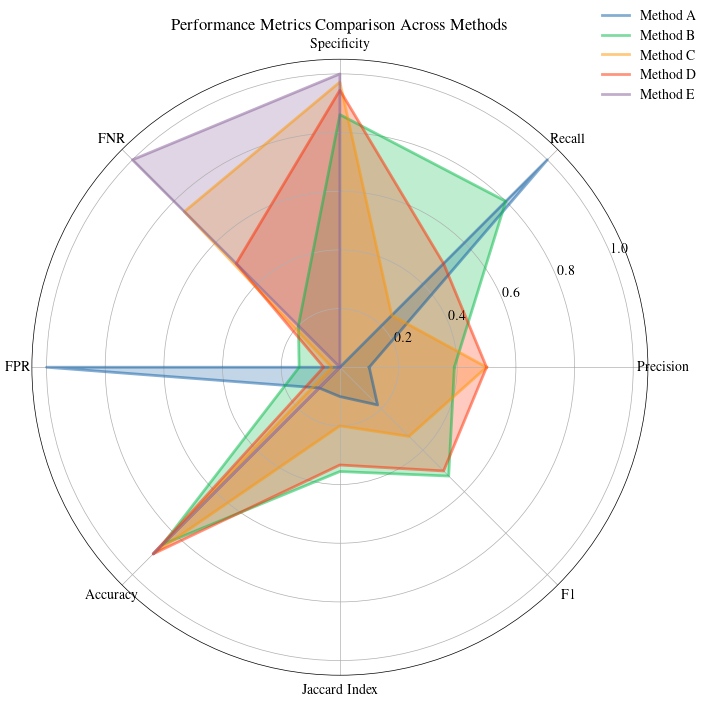

In [22]:
def plot_radar_chart(metrics_df: pd.DataFrame, metrics: List[str], method_col: str = "Method", output_folder:str = OUTPUT_FOLDER) -> None:
    """
    Plots a radar (spider) chart for all methods in a single plot, showing the performance across all specified metrics.

    Parameters:
    -------------
    metrics_df (pd.DataFrame): DataFrame containing the metrics scores for each method.
    metrics (List[str]): List of metric column names to plot (e.g., ["Precision", "Recall", "Accuracy", ...]).
    method_col (str): Column name that contains the model/method name.

    Returns:
    -------------
    None
    """
    # Number of metrics to plot
    num_metrics = len(metrics)
    
    # Angles for the radar chart (one per metric plus a closing angle for circularity)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Plot each method with a unique color
    for _, row in metrics_df.iterrows():
        method_name = row[method_col]
        values = row[metrics].tolist()
        values += values[:1]  # Close the loop
        
        # Plot data and fill area for each method
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Method {method_name}", alpha=0.5)
        ax.fill(angles, values, alpha=0.25)

    # Add labels for each metric
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    
    # Set the title and legend
    plt.title("Performance Metrics Comparison Across Methods")
    ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
    
    # Display the plot
    plt.savefig(f"{output_folder}/radar_plot.png")
    plt.show()

        
plot_radar_chart(metrics_df = performance, metrics = performance.columns[1:], method_col = "Method")

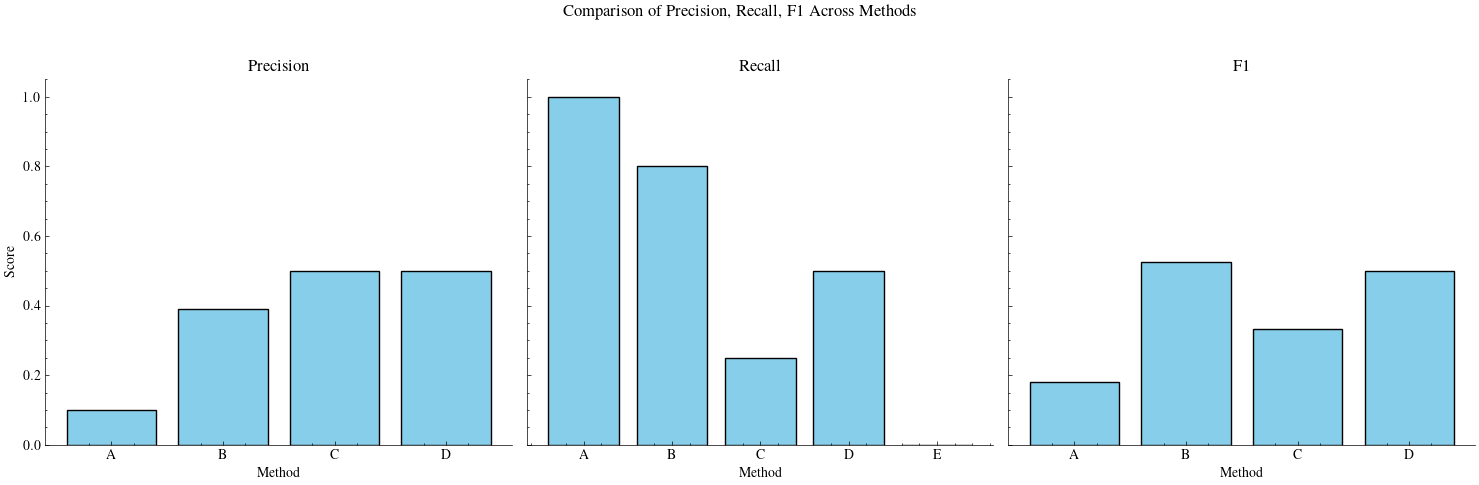

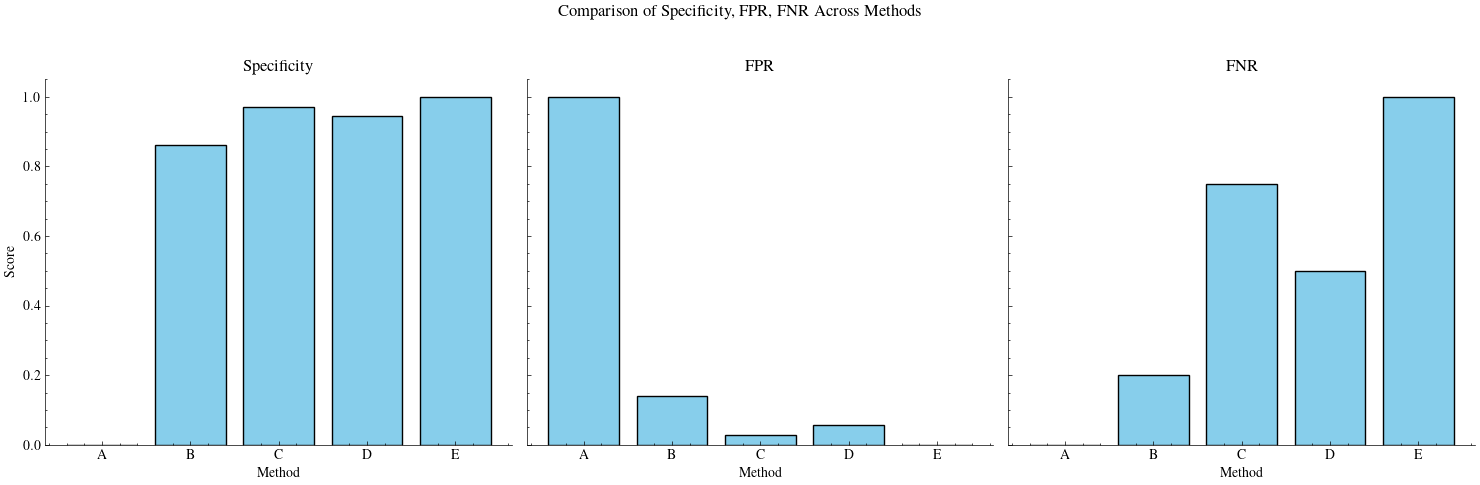

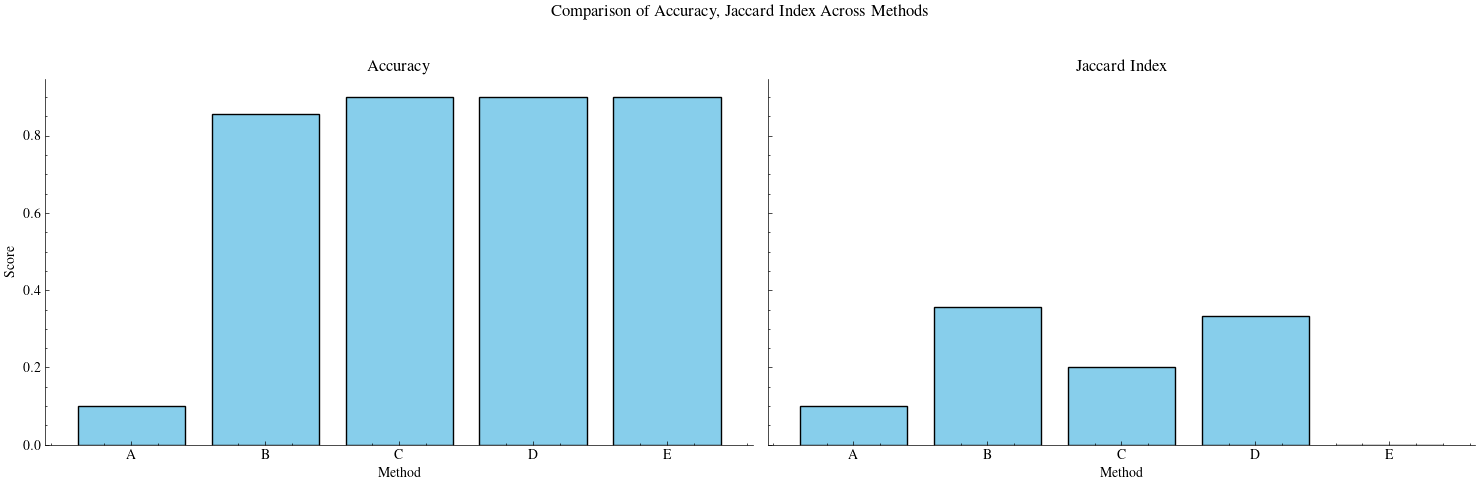

In [23]:
def plot_metric_bar_groups(metrics_df: pd.DataFrame, method_col: str = "Method", output_folder:str = OUTPUT_FOLDER) -> None:
    """
    Creates bar plots for grouped metrics to compare model performance.

    Parameters:
    -------------
    metrics_df (pd.DataFrame): DataFrame containing the metrics scores for each method.
    method_col (str): Column name that contains the model/method name.

    Returns:
    -------------
    None
    """
    # Define metric groups
    metric_groups = [
        ["Precision", "Recall", "F1"],
        ["Specificity", "FPR", "FNR"],
        ["Accuracy", "Jaccard Index"]
    ]

    # Generate bar plots for each metric group
    for group in metric_groups:
        fig, axes = plt.subplots(1, len(group), figsize=(15, 5), sharey=True)
        
        # Iterate over each metric in the group to create a bar plot
        for i, metric in enumerate(group):
            axes[i].bar(metrics_df[method_col], metrics_df[metric], color='skyblue', edgecolor='black')
            axes[i].set_title(metric)
            axes[i].set_xlabel("Method")
            if i == 0:
                axes[i].set_ylabel("Score")
            
            # Disable specified axes
            axes[i].spines[['right', 'top']].set_visible(False)
            axes[i].get_xaxis().tick_bottom()
            axes[i].get_yaxis().tick_left()
        
        # Adjust layout for the entire figure
        plt.suptitle(f"Comparison of {', '.join(group)} Across Methods")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        
        plt.savefig(f"{output_folder}/barplot_{''.join(group)}_comparison.png")
        plt.show()

# Example usage with metrics DataFrame
# metrics_df = your_calculated_metrics_dataframe
plot_metric_bar_groups(metrics_df=performance)

In [24]:
# Find the maximum value per row and the corresponding method
max_values = performance_per_row.max(axis=1)
max_methods = performance_per_row.idxmax(axis=1)

# Combine results into a single DataFrame for easy viewing
max_results = pd.DataFrame({"Max Value": max_values, "Method": max_methods})
max_results

,Max Value,Method
Precision,0.500000,C
Recall,1.000000,A
Specificity,1.000000,E
FNR,1.000000,E
FPR,1.000000,A
Accuracy,0.900000,C
Jaccard Index,0.355556,B
F1,0.524590,B
